<a href="https://colab.research.google.com/github/Sithum02/Image-Colorizer-using-U-Net-VGG16/blob/main/Automatic_Colourizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sithumdezoysa","key":"49f813c312f4f752b5649c3afd2703e9"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download bobaaayoung/place365



Dataset URL: https://www.kaggle.com/datasets/bobaaayoung/place365
License(s): unknown
 99% 674M/681M [00:01<00:00, 282MB/s]
100% 681M/681M [00:03<00:00, 182MB/s]


In [4]:
!unzip -q place365.zip

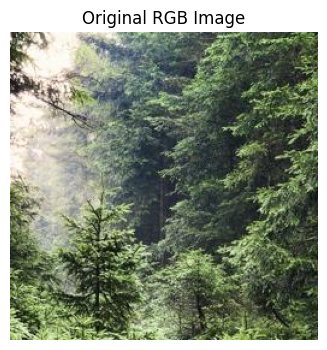

In [5]:
import cv2
import matplotlib.pyplot as plt
import glob

# Pick one sample image
sample_path = glob.glob('/content/DATA-1/natural/forest/00000002.jpg')[0]
img_bgr = cv2.imread(sample_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,4))
plt.imshow(img_rgb)
plt.title("Original RGB Image")
plt.axis('off')
plt.show()


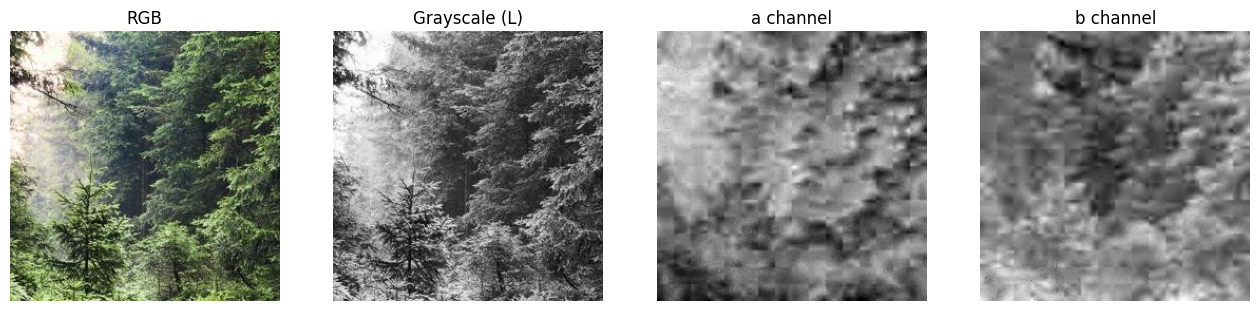

In [6]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)

L_channel, a_channel, b_channel = cv2.split(img_lab)

fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].imshow(img_rgb)
ax[0].set_title('RGB')
ax[0].axis('off')

ax[1].imshow(img_gray, cmap='gray')
ax[1].set_title('Grayscale (L)')
ax[1].axis('off')

ax[2].imshow(a_channel, cmap='gray')
ax[2].set_title('a channel')
ax[2].axis('off')

ax[3].imshow(b_channel, cmap='gray')
ax[3].set_title('b channel')
ax[3].axis('off')

plt.show()


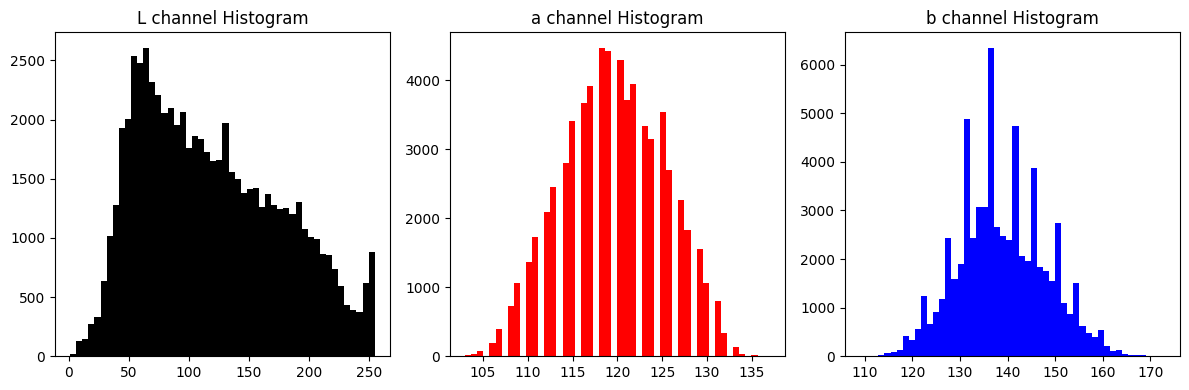

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(L_channel.ravel(), bins=50, color='black')
plt.title('L channel Histogram')

plt.subplot(1,3,2)
plt.hist(a_channel.ravel(), bins=50, color='red')
plt.title('a channel Histogram')

plt.subplot(1,3,3)
plt.hist(b_channel.ravel(), bins=50, color='blue')
plt.title('b channel Histogram')

plt.tight_layout()
plt.show()


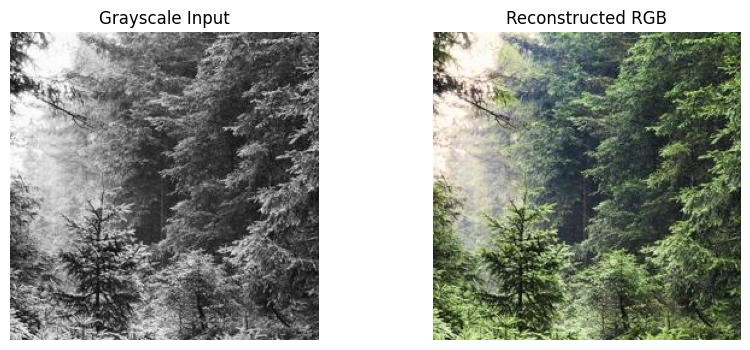

In [8]:
# Simulate pipeline: Take L from grayscale, combine with original a,b
lab_reconstructed = cv2.merge([L_channel, a_channel, b_channel])
img_reconstructed = cv2.cvtColor(lab_reconstructed, cv2.COLOR_Lab2RGB)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Input')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_reconstructed)
plt.title('Reconstructed RGB')
plt.axis('off')

plt.show()


In [9]:
import os
import glob

# Root dataset path
DATA_ROOT = '/content/DATA-1'

# Get all image paths recursively
image_paths = glob.glob(os.path.join(DATA_ROOT, '**', '*.jpg'), recursive=True)
print(f"Total images found: {len(image_paths)}")

# Peek at a few paths
for p in image_paths[:10]:
    print(p)


Total images found: 50000
/content/DATA-1/natural/forest/00002024.jpg
/content/DATA-1/natural/forest/00003944.jpg
/content/DATA-1/natural/forest/00004929.jpg
/content/DATA-1/natural/forest/00002063.jpg
/content/DATA-1/natural/forest/00000488.jpg
/content/DATA-1/natural/forest/00002060.jpg
/content/DATA-1/natural/forest/00003439.jpg
/content/DATA-1/natural/forest/00001181.jpg
/content/DATA-1/natural/forest/00002208.jpg
/content/DATA-1/natural/forest/00003792.jpg


In [10]:
import tensorflow as tf
import numpy as np
import cv2

IMG_SIZE = 256  # can be changed to 224 or 128 if memory is low

def preprocess_image(path):
    # Read image with OpenCV
    img_bgr = cv2.imread(path.numpy().decode('utf-8')) # Decode the byte string from the EagerTensor
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))

    # Convert to Lab
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
    L, a, b = cv2.split(img_lab)

    # Normalize
    L = L / 255.0  # [0,1]
    a = (a - 128) / 128.0  # [-1,1]
    b = (b - 128) / 128.0  # [-1,1]

    # Stack a and b
    ab = np.stack([a, b], axis=-1)

    # Return as float32
    return L.astype(np.float32), ab.astype(np.float32)

In [11]:
def load_and_preprocess(path):
    # Call your existing preprocessing
    L, ab = tf.py_function(preprocess_image, [path], [tf.float32, tf.float32])
    # Explicitly set shapes
    L.set_shape([IMG_SIZE, IMG_SIZE])        # 2D grayscale
    ab.set_shape([IMG_SIZE, IMG_SIZE, 2])    # 2D with 2 color channels
    # 🔹 Add channel dimension to L to match model input
    L = tf.expand_dims(L, axis=-1)  # shape -> (IMG_SIZE, IMG_SIZE, 1)

    return L, ab


In [12]:
BATCH_SIZE = 8
BUFFER_SIZE = 1000  # for shuffling

dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)



L batch shape: (8, 256, 256, 1)
ab batch shape: (8, 256, 256, 2)


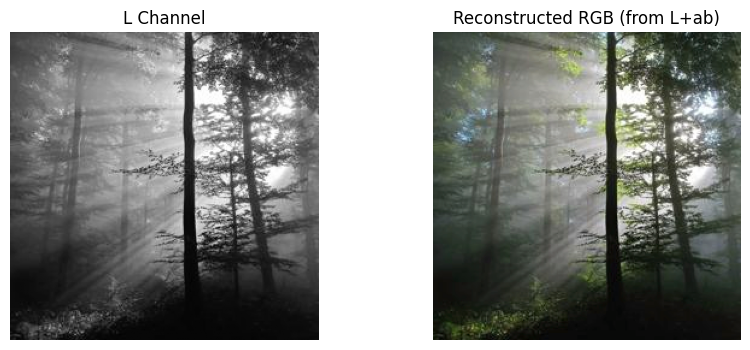

In [13]:
import matplotlib.pyplot as plt

for L_batch, ab_batch in dataset.take(1):
    print("L batch shape:", L_batch.shape)
    print("ab batch shape:", ab_batch.shape)

    # Take one sample
    L = L_batch[0].numpy().squeeze()  # (H, W)
    ab = ab_batch[0].numpy()          # (H, W, 2)

    # Convert back to Lab
    L_img = (L * 255).astype(np.uint8)
    a_img = (ab[...,0] * 128 + 128).astype(np.uint8)
    b_img = (ab[...,1] * 128 + 128).astype(np.uint8)
    lab_img = cv2.merge([L_img, a_img, b_img])

    rgb_reconstructed = cv2.cvtColor(lab_img, cv2.COLOR_Lab2RGB)

    # Show side by side
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(L, cmap='gray')
    plt.title('L Channel')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(rgb_reconstructed)
    plt.title('Reconstructed RGB (from L+ab)')
    plt.axis('off')
    plt.show()


In [14]:
image_count = len(image_paths)
val_size = int(0.1 * image_count)

train_paths = image_paths[val_size:]
val_paths = image_paths[:val_size]

train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = val_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16


In [16]:
IMG_SIZE = 256

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='L_input')
# Tile 1 channel → 3 channels
x = layers.Concatenate()([inputs, inputs, inputs])   # shape: (256,256,3)


In [17]:
# Load pretrained VGG16
vgg = VGG16(include_top=False, weights='imagenet', input_tensor=x)

# Optionally freeze encoder weights
for layer in vgg.layers:
    layer.trainable = False

# Extract skip connections (like U-Net)
skip1 = vgg.get_layer('block1_conv2').output   # 256x256 → 256x256
skip2 = vgg.get_layer('block2_conv2').output   # 128x128
skip3 = vgg.get_layer('block3_conv3').output   # 64x64
skip4 = vgg.get_layer('block4_conv3').output   # 32x32

# Bottleneck
bottleneck = vgg.get_layer('block5_conv3').output  # 16x16


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Decoder Block 1 (16x16 → 32x32)
d1 = layers.UpSampling2D((2,2))(bottleneck)
d1 = layers.Concatenate()([d1, skip4])
d1 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(d1)
d1 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(d1)

# Decoder Block 2 (32x32 → 64x64)
d2 = layers.UpSampling2D((2,2))(d1)
d2 = layers.Concatenate()([d2, skip3])
d2 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(d2)
d2 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(d2)

# Decoder Block 3 (64x64 → 128x128)
d3 = layers.UpSampling2D((2,2))(d2)
d3 = layers.Concatenate()([d3, skip2])
d3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(d3)
d3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(d3)

# Decoder Block 4 (128x128 → 256x256)
d4 = layers.UpSampling2D((2,2))(d3)
d4 = layers.Concatenate()([d4, skip1])
d4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(d4)
d4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(d4)


In [19]:
outputs = layers.Conv2D(2, (1,1), activation='tanh', padding='same', name='ab_output')(d4)


In [20]:
model = models.Model(inputs=inputs, outputs=outputs, name='Colorization_UNet_VGG16')

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',    # mean squared error between predicted ab and true ab
    metrics=['mae']
)

model.summary()


Model: "Colorization_UNet_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ L_input             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ L_input[0][0],    │
│ (Concatenate)       │ 3)                │            │ L_input[0][0],    │
│                     │                   │            │ L_input[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ concatenate[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,891,202 (94.95 MB)

 Trainable params: 10,176,514 (38.82 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)


Epoch 1/50
2843/5625 ━━━━━━━━━━━━━━━━━━━━ 15:17 330ms/step - loss: 0.8704 - mae: 0.9286